# Exercise

Let's have some fun with Gemini and the open-source models!

First, make sure you have setup your credentials. Move to the *_parent folder_* and do this:

```bash
cp env.example .env
```

Then open .env in the same folder and insert your API key for Gemini, like this:

```yaml
GEMINI_API_KEY=[your key]
...rest of the file
```
while leaving the rest untouched.

Then we can load the credentials like this:

In [ ]:
# Load credentials for Gemini
from dotenv import load_dotenv

# NOTE: since our .env file is in the parent directory, we load from
# "../.env". In Linux and Mac, ".." means "the parent folder of the current folder"
load_dotenv("../.env")

# Only needed on the Udacity workspace. Comment this out if running on another system.
import os
os.environ['HF_HOME'] = '/voc/data/huggingface'
os.environ['OLLAMA_MODELS'] = '/voc/data/ollama/cache'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['PATH'] = f"/voc/data/ollama/bin:/voc/data/ffmpeg/bin:{os.environ.get('PATH', '')}"
os.environ['LD_LIBRARY_PATH'] = f"/voc/data/ollama/lib:/voc/data/ffmpeg/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"

True

Next, let's create some utility functions that we will use later:

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def get_image_from_url(image_url: str) -> Image.Image:
    
    return Image.open(
        BytesIO(
            requests.get(image_url).content
        )
    )
    

def display_image_with_caption(image: Image.Image, caption: str):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption, wrap=True, fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


and let's prepare the data we are going to use:

**NOTE**: because the image is generated randomly, if you run this cell multiple times you will get a different image every time

In [ ]:

# This URL generates a random JPG image every time you call it!
image_url = "https://picsum.photos/400/300"
image = get_image_from_url(image_url)

# The following is for huggingface
def get_huggingface_messages(img: Image.Image, prompt: str):

    # TODO: Fill in the right content with the format expected by huggingface
    # chat models
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": prompt},
            ]
        },
    ]

    return messages

## Image analysis with Gemini

Let's use Gemini to list all objects that are present in our image:

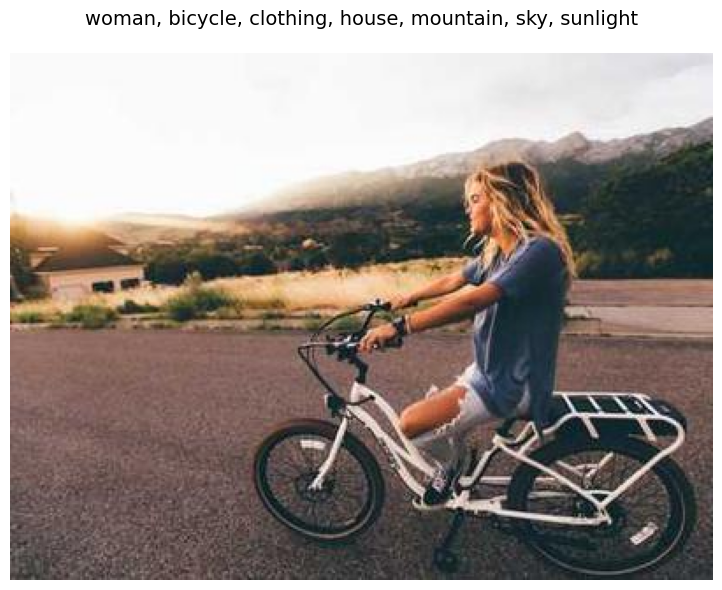

In [17]:
import os
from google import genai
from google.genai import types

# NOTE: here we could ask for a caption, instead we ask to list the objects in a
# specific way
prompt = "List all objects that are present in this image as a comma-separated list."


def analyze_image_with_gemini(img: Image.Image, prompt: str) -> str:
    
    # TODO: create a genai.Client instance using your API key
    client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))

    # Set thinking to 0 to save some money and get a faster response
    config = types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )

    # Limit size to at most 600x600 to limit the usage of tokens
    img.thumbnail((600, 600))

    # Format image for Gemini call
    image_bytes = BytesIO()
    img.save(image_bytes, format='JPEG')
    image_part = types.Part.from_bytes(
        data=image_bytes.getvalue(), 
        mime_type='image/jpeg'
    )

    # TODO: call Gemini. Use the model "gemini-2.5-flash-lite" and pass in as contents
    # your prompt and the image_part we have just created, as well as the config
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=[prompt, image_part],
        config=config
    )
    
    return response.text


caption = analyze_image_with_gemini(
    image,
    prompt
)

display_image_with_caption(image, caption)

Experiment with the prompt and see all the things you can ask Gemini to do!

## SmolVLM2 on Hugging Face

Now let's do the same, but this time we use an open-source model locally (no external API call). We use one of the best small Visual Language Models, SmolVLM2. It fits confortably in our T4 GPU and it can do a lot of interesting things:

Device is cpu


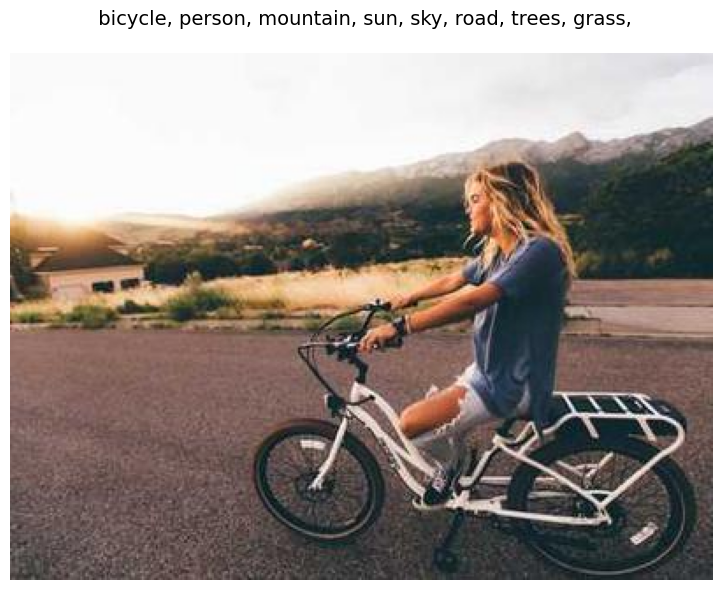

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch

model_name = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"

# TODO: create an instance of the AutoProcessor for the model
# specified in model_path using AutoProcessor.from_pretrained
processor = AutoProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

# TODO: Create an instance of the model using the .from_pretrained
# method of the AutoModelForImageTextToText class.
# Looking at the documentation for this model, we must add the
# following keywords as well: "torch_dtype=torch.float16" and
# device_map="auto"
model = AutoModelForImageTextToText.from_pretrained(
    model_name,
    torch_dtype=torch.float16, device_map="auto"
)

# This is taken from the documentation of the model, some
# options are required some are optional
inputs = processor.apply_chat_template(
    # TODO: get the messages template for huggingface using the
    # get_huggingface_messages function we defined above
    get_huggingface_messages(image, prompt),
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device, dtype=torch.float16)

# This takes around 10 seconds on GPU, around 4 minutes on a CPU
# TODO: use the model by calling the .generate method and passing
# the inputs we have created (use `**inputs`). Use also max_new_tokens
# to limit the output and the time it takes to generate it. Start with 16
# and increase it if you see that the output is truncated
generated_ids = model.generate(
    **inputs, 
    # If the output gets trucnated, try increasing this
    max_new_tokens=16,
)

# TODO: decode the output from the model to transform it back
# to text
generated_texts = processor.batch_decode(
    # Remember to slice to avoid decoding your input prompt
    generated_ids[:, inputs['input_ids'].shape[1]:],
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True
)
result = generated_texts[0]

display_image_with_caption(image, result)

## Audio processing with Gemini

Now let's see what Gemini can do with audio:

In [14]:
import os
from google import genai
from google.genai import types
from IPython.display import Audio, display

prompt = "Transcribe this audio file."


def analyze_audio_with_gemini(audio_bytes: bytes, prompt: str) -> str:
    
    client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))

    config = types.GenerateContentConfig(
        # Set thinking to 0 to save some money and get a faster response
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )

    # Format audio for Gemini call
    # Earlier we had:
    # image_part = types.Part.from_bytes(data=image_bytes.getvalue(), mime_type='image/jpeg')
    # to get an image part, now we get an audio part in a similar way:
    audio_part = types.Part.from_bytes(data=audio_bytes, mime_type='audio/wav')

    # Call Gemini
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        # TODO: here pass in the audio part instead of the image part as we did
        # before. Everything else stays the same
        contents=[prompt, audio_part],
        config=config
    )
    
    return response.text


# Example usage with WAV file bytes
# Assuming you have audio_bytes containing WAV file data
audio_bytes = open("../LJ025-0076.wav", "rb").read()
caption = analyze_audio_with_gemini(
    audio_bytes,
    prompt
)

display(Audio("../LJ025-0076.wav"))

print(caption)

Many animals of even complex structure which live parasitically within others are wholly devoid of an elementary cavity.


## Audio processing with Whisper

And now let's do the same with an open-source specialized audio model, Whisper:

In [ ]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3-turbo"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

# This takes a few seconds on a T4 GPU and around 1 m on CPU
# TODO: here we use the "pipeline" system of huggingface, available
# from some pre-defined tasks, that simplifies all the steps and reduce
# the boilerplate we need to write
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

# NOTE: this requires ffmpeg to be installed in your system
# This is the text spoken in this file:
# Many animals of even complex structure which live parasitically within others are wholly devoid of an alimentary cavity.
result: dict = pipe("../LJ025-0076.wav")

print("==============")
print(result.get('text'))

Device set to use cpu


 many animals of even complex structure which live parasitically within others are wholly devoid of an alimentary cavity
